# Coding Competition
## Recurrent Neural Networks (RNN)
This assignment ask you to forecast the stock price using RNN and LSTM.
#### RNN
- **Model Input:** Replace the stock_symbol using the stock you obtained from the drawlot. Do not change the start_date to end_date, price_type or scaler.
- **Model Processing:** Do not change how the train and the test are split, the loss function and the optimizer. Please fix the number of features = 1. Change the window_size, the hidden_units, the number of epochs, the activation function and the batch_size.
- **Model Output:** present the model with the smallest Test RMSE next week. Share with us (1) your understanding on each step, (2) observation on how the hyperparameter choice could impact the result and (3) any insights.

### Imports & Settings

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from pathlib import Path

import numpy as np
import pandas as pd
import pandas_datareader.data as web
from scipy.stats import spearmanr

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from tensorflow.keras.layers import Dense, LSTM
from tensorflow import keras

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
import yfinance as yf

### Model Input

[*********************100%***********************]  1 of 1 completed


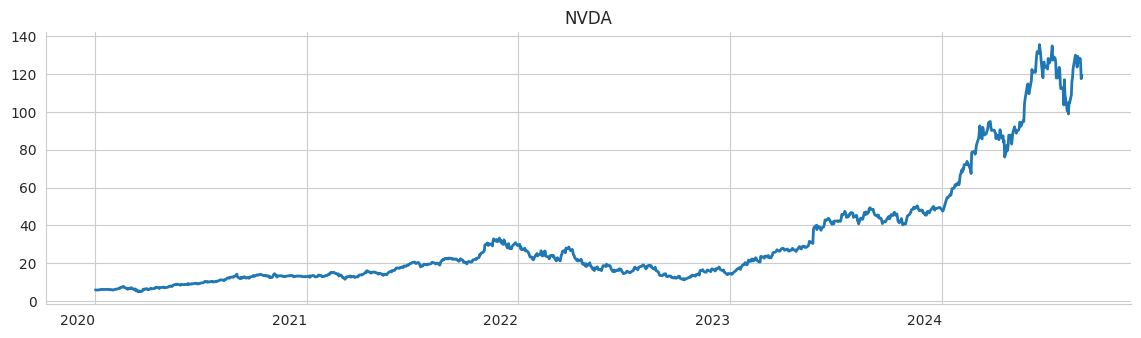

In [ ]:
# set up the random state
sns.set_style('whitegrid')
np.random.seed(42)

start_date = datetime(2020,1,1)
end_date = datetime(2024,8,31)
stock_symbol = 'NVDA'

# Download stock data from yahoo finance
stocks = yf.download('NVDA',start_date ,end_date)
price_type = 'Adj Close'
stock_price = pd.DataFrame(stocks[price_type])

ax = stock_price.plot(title = stock_symbol, legend=False, linewidth = 2, figsize=(14, 4), rot=0)
ax.set_xlabel('')
sns.despine()

In [ ]:
scaler = MinMaxScaler()
stocks_scaled = pd.Series(scaler.fit_transform(stock_price.values.reshape(-1, 1)).squeeze(),
                         index = stock_price.index)

### Model Processing

In [ ]:
def create_univariate_rnn_data(data, window_size):
    n = len(data)
    y = data[window_size:]
    data = data.values.reshape(-1, 1) # make 2D
    X = np.hstack(tuple([data[i: n-j, :] for i, j in enumerate(range(window_size, 0, -1))]))
    return pd.DataFrame(X, index=y.index), y

window_size = 60
X, y = create_univariate_rnn_data(stocks_scaled, window_size = window_size)

# Train-test split
X_train = X[:'2022'].values.reshape(-1, window_size, 1)
y_train = y[:'2022']
y_train.shape

n_obs, window_size, n_features = X_train.shape
# keep the last year for testing
X_test = X['2023':].values.reshape(-1, window_size, 1)
y_test = y['2023':]

In [ ]:
X_train.shape

(696, 60, 1)

In [ ]:
def create_RNN(hidden_units, dense_units, input_shape, activation):
    model = Sequential() # clarify hidden states vs hidden layers
    model.add(SimpleRNN(hidden_units, input_shape = input_shape, activation=activation[1]))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

# Create model and train
rnn = create_RNN(hidden_units = 7, dense_units = 1, input_shape = (window_size, n_features),
                   activation=['tanh', 'relu'])
rnn.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)             │ (None, 7)                   │              63 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │               8 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 71 (284.00 B)

 Trainable params: 71 (284.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
RNN_training = rnn.fit(X_train,
                       y_train,
                       epochs = 80,
                       batch_size = 30,
                       validation_data = (X_test, y_test),
                       verbose=1)

Epoch 1/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0052 - val_loss: 0.1136
Epoch 2/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0016 - val_loss: 0.0852
Epoch 3/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0010 - val_loss: 0.0756
Epoch 4/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9.0947e-04 - val_loss: 0.0729
Epoch 5/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 8.8007e-04 - val_loss: 0.0655
Epoch 6/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 7.3783e-04 - val_loss: 0.0584
Epoch 7/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 6.5782e-04 - val_loss: 0.0500
Epoch 8/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 5.3855e-04 - val_loss: 0.0416
Epoch 9/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 4.2661e-04 - val_loss: 0.0319
Epoch 10/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.5558e-04 - val_loss: 0.0229
Epoch 11/80
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.6878e-04 - val_loss: 0.0155
Epoch 12/80
24/24 ━━━━━━━━━━━━━

### Model Output

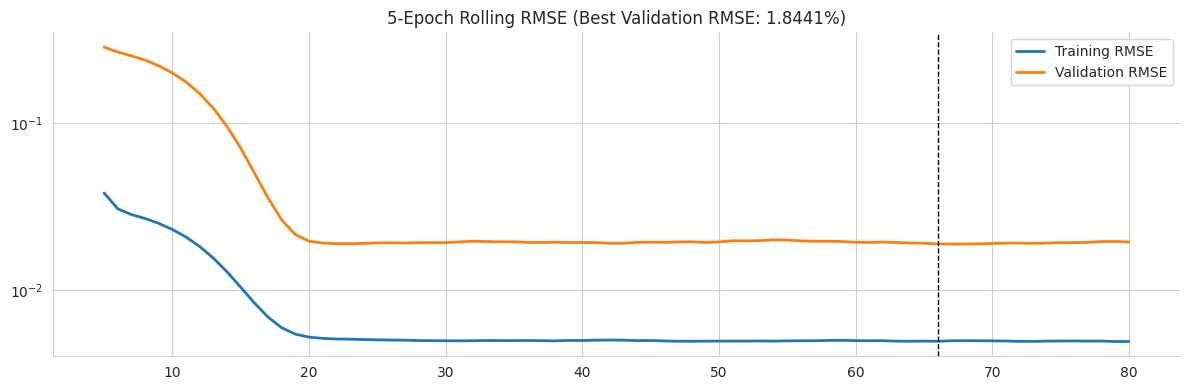

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))

loss_history = pd.DataFrame(RNN_training.history).pow(.5)
loss_history.index += 1
best_rmse = loss_history.val_loss.min()

best_epoch = loss_history.val_loss.idxmin()

title = f'5-Epoch Rolling RMSE (Best Validation RMSE: {best_rmse:.4%})'
loss_history.columns=['Training RMSE', 'Validation RMSE']
loss_history.rolling(5).mean().plot(logy=True, lw=2, title=title, ax=ax)

ax.axvline(best_epoch, ls='--', lw=1, c='k')

sns.despine()
fig.tight_layout()

In [ ]:
train_rmse_scaled = np.sqrt(rnn.evaluate(X_train, y_train, verbose=0))
test_rmse_scaled = np.sqrt(rnn.evaluate(X_test, y_test, verbose=0))
print(f'Train RMSE (scaled): {train_rmse_scaled:.4f} | Test RMSE (scaled): {test_rmse_scaled:.4f}')

Train RMSE (scaled): 0.0049 | Test RMSE (scaled): 0.0193


In [ ]:
train_predict_scaled = rnn.predict(X_train)
test_predict_scaled = rnn.predict(X_test)

train_ic = spearmanr(y_train, train_predict_scaled)[0]
test_ic = spearmanr(y_test, test_predict_scaled)[0]
print(f"Train IC: {train_ic:.4f} | Test IC: {test_ic:.4f}")

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Train IC: 0.9917 | Test IC: 0.9949


**Rescale Predictions**

In [ ]:
train_predict = pd.Series(scaler.inverse_transform(train_predict_scaled).squeeze(), index=y_train.index)
test_predict = (pd.Series(scaler.inverse_transform(test_predict_scaled).squeeze(), index=y_test.index))
# use inverse_transform to convert the scaled data back to its original scale.
y_train_rescaled = scaler.inverse_transform(y_train.to_frame()).squeeze()
y_test_rescaled = scaler.inverse_transform(y_test.to_frame()).squeeze()

In [ ]:
train_rmse = np.sqrt(mean_squared_error(train_predict, y_train_rescaled))
test_rmse = np.sqrt(mean_squared_error(test_predict, y_test_rescaled))
print(f"Train RMSE: {train_rmse:.2f} | Test RMSE: {test_rmse:.2f}")

Train RMSE: 0.64 | Test RMSE: 2.52


In [ ]:
stock_price['Train Predictions'] = train_predict
stock_price['Test Predictions'] = test_predict

to_be_merged = pd.concat([train_predict.to_frame('predictions').assign(data='Train'),
                   test_predict.to_frame('predictions').assign(data='Test')])

stock_price = pd.merge(stock_price, to_be_merged, how='inner', on = 'Date')
# remove the suffixes brought by pd.merge()
stock_price.columns = stock_price.columns.str.rstrip('_x').str.rstrip('_y')

### Visualization

In [ ]:
stock_price

,Adj Close,Train Predictions,Test Predictions,predictions,data
Date,,,,,
2020-03-30,6.616442,6.470682,NaN,6.470682,Train
2020-03-31,6.566866,6.660260,NaN,6.660260,Train
2020-04-01,6.055418,6.644297,NaN,6.644297,Train
2020-04-02,6.364330,6.425285,NaN,6.425285,Train
2020-04-03,6.076344,6.524559,NaN,6.524559,Train
...,...,...,...,...,...
2024-08-26,126.449181,NaN,126.688026,126.688026,Test
2024-08-27,128.289032,NaN,126.256607,126.256607,Test
2024-08-28,125.599258,NaN,126.738647,126.738647,Test


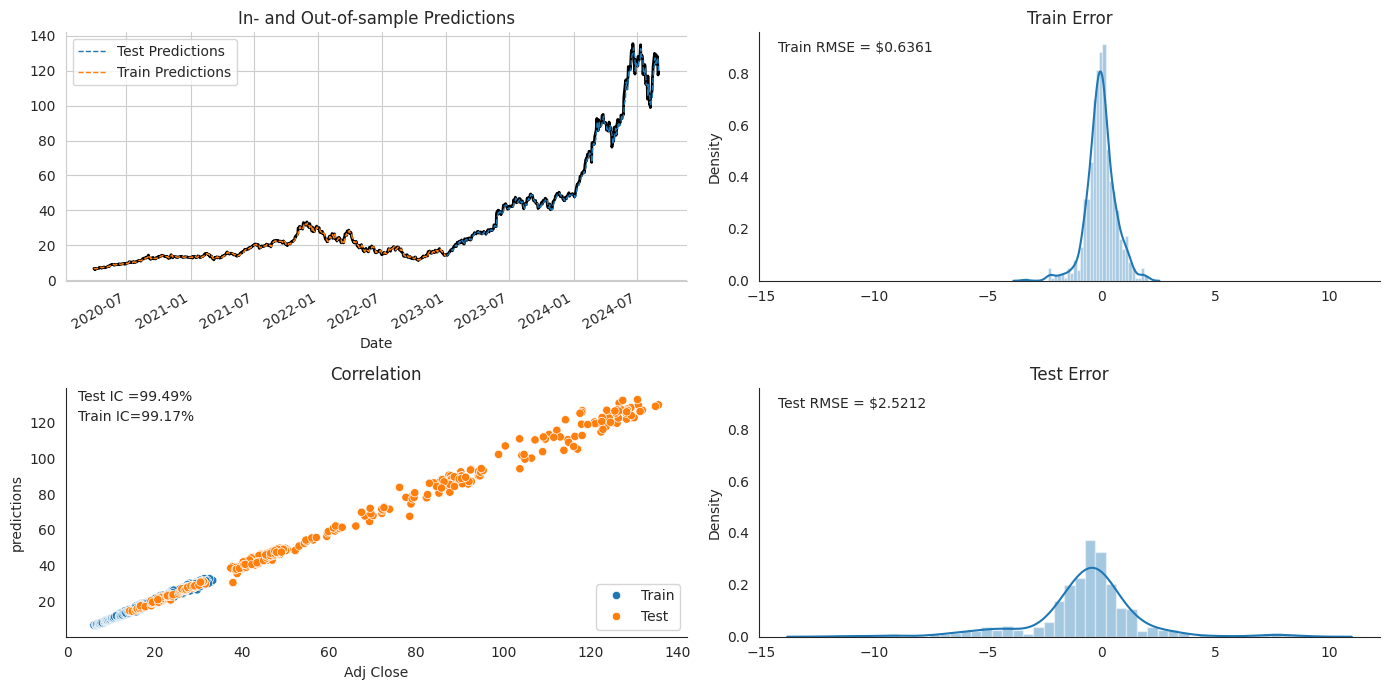

In [ ]:
fig=plt.figure(figsize=(14,7))
ax1 = plt.subplot(221)
stock_price.loc['2020':, price_type].plot(lw=2, ax=ax1, c='k')
stock_price.loc['2020':, ['Test Predictions', 'Train Predictions']].plot(lw=1, ax=ax1, ls='--')
ax1.set_title('In- and Out-of-sample Predictions')

with sns.axes_style("white"):
    ax3 = plt.subplot(223)
    sns.scatterplot(x = price_type, y = 'predictions', data = stock_price, hue = 'data', ax = ax3)
    ax3.text(x=.02, y=.95, s=f'Test IC ={test_ic:.2%}', transform=ax3.transAxes)
    ax3.text(x=.02, y=.87, s=f'Train IC={train_ic:.2%}', transform=ax3.transAxes)
    ax3.set_title('Correlation')
    ax3.legend(loc='lower right')

    ax2 = plt.subplot(222)
    ax4 = plt.subplot(224, sharex = ax2, sharey=ax2)
    sns.distplot(train_predict.squeeze()- y_train_rescaled, ax=ax2)
    ax2.set_title('Train Error')
    ax2.text(x=.03, y=.92, s=f'Train RMSE = ${train_rmse:.4f}', transform=ax2.transAxes)
    sns.distplot(test_predict.squeeze()-y_test_rescaled, ax=ax4)
    ax4.set_title('Test Error')
    ax4.text(x=.03, y=.92, s=f'Test RMSE = ${test_rmse:.4f}', transform=ax4.transAxes)

sns.despine()
fig.tight_layout()